In [13]:
from discretizer import discretizer
from client import client
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from server import server_twosample_U, server_twosample_chi, server_twosample_projection
from data_generator import data_generator
import time
import numpy

In [14]:
t = time.time()

server_now = server_twosample_projection(device)
data_gen = data_generator(device)
alphabet_size = 4
beta = 0.5
privacy_level = 100
n_test = 10000
significance_level = 0.05
sample_size = 1000
test_result = torch.zeros(n_test).to(device)
test_statistic = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_bitFlip(privacy_level)
    #test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, n_permutation)
    test_statistic[i]  = server_now._calculate_statistic(data_y_priv, data_z_priv)
    
elapsed = time.time() - t
elapsed

6.8224053382873535

In [17]:
alphabet_size

4

In [16]:
test_statistic

tensor([2.6860e-06, 2.7920e-06, 6.9000e-07,  ..., 1.3640e-06, 5.1800e-07,
        6.0000e-07])

(array([265., 387., 425., 454., 552., 492., 469., 506., 445., 418., 462.,
        362., 364., 340., 309., 284., 282., 246., 232., 189., 253., 185.,
        183., 163., 162., 129., 109., 103., 105., 108., 101.,  74.,  77.,
         73.,  61.,  49.,  66.,  43.,  48.,  45.,  38.,  33.,  26.,  28.,
         22.,  21.,  17.,  21.,  25.,  13.,  16.,  10.,   6.,  11.,  10.,
          6.,   7.,   6.,   4.,   8.,   2.,   2.,   6.,   5.,   3.,   3.,
          2.,   2.,   3.,   2.,   1.,   1.,   2.,   1.,   2.,   1.,   0.,
          4.,   0.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          2.]),
 array([9.45236841e-03, 2.15395479e-01, 4.21338589e-01, 6.27281699e-01,
        8.33224809e-01, 1.03916792e+00, 1.24511103e+00, 1.45105414e+00,
        1.65699725e+00, 1.86294036e+00, 2.06888347e+00, 2.27482658e+00,
        2.48076969e+00, 2.68671280e+00, 2.89265591e+00, 3.09859902e+00,
        3.30454213e+00, 3.5104

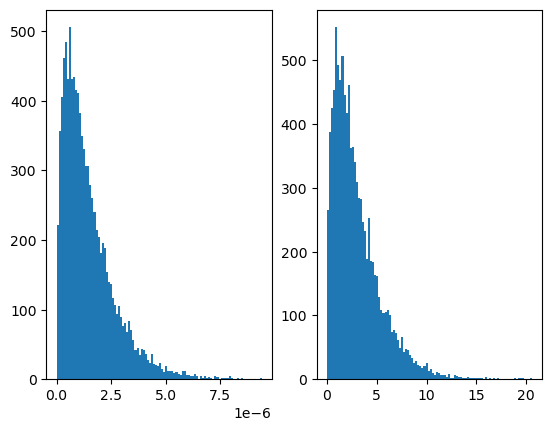

In [15]:
fig, axs = plt.subplots(1,2)
axs[0].hist(test_statistic, bins =100)
axs[1].hist(numpy.random.chisquare(alphabet_size-1, 10000), bins =100)

In [11]:
numpy.random.chisquare(alphabet_size-1, 10000)

array([3.12911011, 4.46915588, 7.67141197, ..., 0.63649142, 2.48654217,
       2.93446103])

In [51]:
a.eq(1).mul(-2)

tensor([[ 0,  0,  0, -2,  0],
        [ 0,  0,  0, -2,  0]])

In [3]:
gen = data_generator(device)

In [51]:
p, p_priv = gen._generate_power_law_p_private(10,2.1, 0.5)

<BarContainer object of 10 artists>

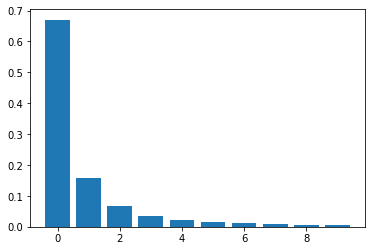

In [52]:
plt.bar(range(10), p.cpu())

<BarContainer object of 10 artists>

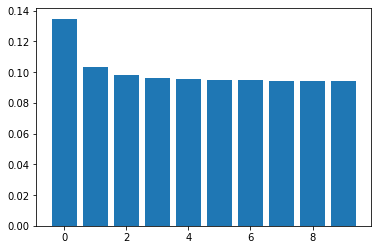

In [53]:
plt.bar(range(10), p_priv.cpu())

In [2]:
t = time.time()

server_now = server_twosample_U(device)
data_gen = data_generator(device)
alphabet_size = 1000
beta = 0.5
privacy_level = 1
n_test = 1
n_permutation = 99
significance_level = 0.05
sample_size = 100000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_LapU(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, n_permutation)
    
    
elapsed = time.time() - t
elapsed

16.566758632659912

In [9]:
(data_y==0).sum()

tensor(1621, device='cuda:0')

In [15]:
torch.tensor([1,2,4]).bincount(minlength=6)

tensor([0, 1, 1, 0, 1, 0])

# performance of GenRR 

In [25]:
t = time.time()

server_now = server_twosample_chi(device)
data_gen = data_generator(device)
alphabet_size = 3000
beta = 2.5
privacy_level = 0.01
n_test = 100
sample_size = 10000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_genRR(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, alphabet_size)
    
    
elapsed = time.time() - t
elapsed

131.28636121749878

In [24]:
(test_result < 0.7).sum()/n_test 

tensor(0.7100, device='cuda:0')

In [6]:
data_y_priv.dtype

torch.int64

# testing the discretizer

In [38]:
p = torch.tensor([0.2, 0.6, 0.1, 0.1])
n_sample = 10
random_multinomial = torch.multinomial(p, n_sample, replacement=True).view(-1)



LDPclient = client(device)
LDPclient.load_data_disc(random_multinomial, random_multinomial, 4)


# testing the LapU for discrete data

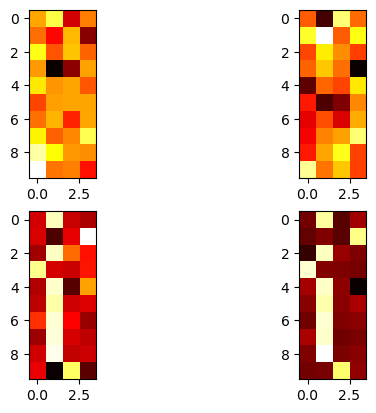

In [43]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_LapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_LapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_LapU(20)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_LapU(50)[1], cmap = 'hot', interpolation = 'nearest')

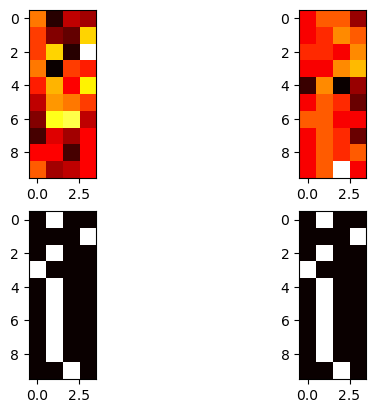

In [42]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(20)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(50)[1], cmap = 'hot', interpolation = 'nearest')

C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\1939938785.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(0.5)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\1939938785.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(1)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\1939938785.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(LDPclient.release_genRR(20)[1]),
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\1939938

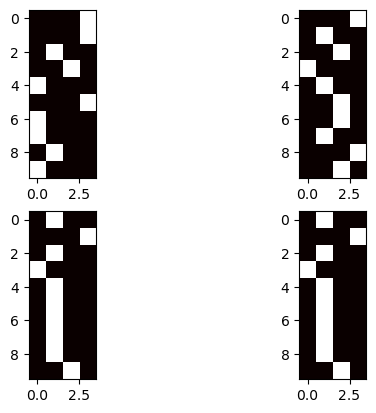

In [45]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(0.5)[1]),
        4
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[0,1].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(1)[1]),
        4
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[1,0].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(20)[1]),
        4
        ),
    cmap = 'hot', interpolation = 'nearest'
)

axs[1,1].imshow(
    torch.nn.functional.one_hot(
        torch.tensor(LDPclient.release_genRR(20)[1]),
        4
        ),
    cmap = 'hot', interpolation = 'nearest'
)

C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[0,0].imshow(torch.tensor(LDPclient.release_bitFlip(0.5)[1]),cmap = 'hot', interpolation = 'nearest')
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axs[0,1].imshow(torch.tensor(LDPclient.release_bitFlip(1)[1]),cmap = 'hot', interpolation = 'nearest')
C:\Users\Jongmin\AppData\Local\Temp\ipykernel_13600\4008632034.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

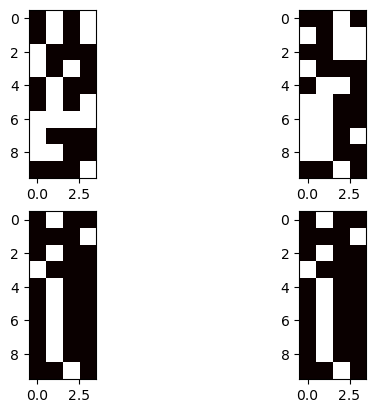

In [46]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(torch.tensor(LDPclient.release_bitFlip(0.5)[1]),cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(torch.tensor(LDPclient.release_bitFlip(1)[1]),cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(torch.tensor(LDPclient.release_bitFlip(10)[1]),cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(torch.tensor(LDPclient.release_bitFlip(10)[1]),cmap = 'hot', interpolation = 'nearest')


In [57]:
a = (LDPclient.release_bitFlip(0.5)[1]).mean(axis=0).view([4,1])
device.type == "cpu"

In [12]:
import numpy
torch.tensor(numpy.linalg.inv(torch.eye(3) - torch.ones(torch.Size([3,3])).numpy())).div(3)

tensor([[ 0.1667, -0.1667, -0.1667],
        [-0.1667,  0.1667, -0.1667],
        [-0.1667, -0.1667,  0.1667]])

In [6]:
torch.ones(torch.Size([3,3])).inverse().div()

RuntimeError: Calling torch.linalg.lu_factor on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

In [ ]:
axs[0,1].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(1), 16)), cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(10), 16)), cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(torch.nn.functional.one_hot(torch.tensor(LDPclient.release_genRR(100), 16)), cmap = 'hot', interpolation = 'nearest')

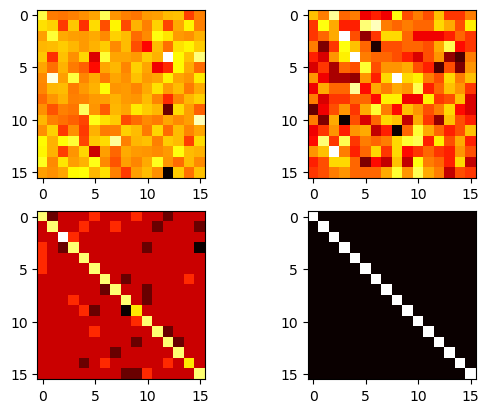

In [9]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')

